In [279]:
import pandas as pd
import requests
import os
import sys
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import tweepy
import types

# 收集

In [280]:
# twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv','r', encoding = False)
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', encoding = "iso-8859-1")
# twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv', sep=r'(?:,|\s+)', engine='python')

In [282]:
# 获取文件推特图片预测 image_predictions
## 1.确定image_predictions 的下载网址链接
image_predictions_url = 'https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/image-predictions.tsv'
## 2.下载和保存文件
response = requests.get(image_predictions_url)
with open('image_predictions.csv', mode = 'wb') as file:
    file.write(response.content)
image_predictions = pd.read_csv('image_predictions.csv', sep = '\t')

In [283]:
# 获取文件3 每条推特的数据
# 直接读取项目提供的tweet_json.txt
tweet_json = pd.read_json('tweet_json.txt',lines = True)

## 从tweet_json中提取三个关键列'id','retweet_count','favorite_count',根据这三个指标建立tweet_keys，方便之后的评价分析。
tweet_info_keys = ['id','retweet_count','favorite_count']
tweet_keys = pd.DataFrame(tweet_json, columns=tweet_info_keys)

In [ ]:
'''
# 利用tweepy来获取。本项目采用直接读取已经提供的tweet_json.txt，如上。
# 将tweet_id存为list
# tweet_ID = np.array(str(twitter_archive_enhanced.tweet_id))
tweet_ID = np.array(twitter_archive_enhanced.tweet_id)
tweet_ID_list = tweet_ID.tolist()

# print(type(tweet_ID_list))

# 利用tweepy 创建tweet_json,并保存为tweet_json.txt
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

# 创建认证对象
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# 设置你的access token和access secret
auth.set_access_token(access_token, access_secret)
# 传入auth参数，创建API对象
# api = tweepy.API(auth, proxy = "127.0.0.1:1080"，wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)
id_of_tweet = []
tweet = []

for id_of_tweet in tweet_ID_list:
    try:
        tweet_new = api.get_status(id_of_tweet, tweet_mode='extended')     
        #tweet_new = api.get_status(str(id_of_tweet), tweet_mode='extended')
        tweetid = tweet_new.id
        retweet_count = tweet_new.retweet_count
        favorite_count = tweet_new.favorite_count
        tweet.append({'id': tweetid, 
                      'retweet_count': retweet_count, 
                      'favorite_count': favorite_count})
    except Exception as e:
        # 输出错误信息
        print(str(tweetid) + ": " + str(e))

tweet_json = pd.DataFrame(tweet, columns = ['id', 'retweet_count', 'favorite_count']) 
tweet_json.to_csv('tweet_json_tweepy.txt')

# 三个关键列'id','retweet_count','favorite_count',根据这三个指标建立tweet_keys，方便之后的评价分析。
tweet_info_keys = ['id','retweet_count','favorite_count']
tweet_keys = pd.DataFrame(tweet_json, columns=tweet_info_keys)

'''

# 评估

##### 质量
###### `WeRateDogs 推特档案(twitter_archive_enhanced)`的评估
- timestamp, retweeted_status_timestamp 应当调整为时间序列
- tweet_id 应当为字符串str
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 采用 fillna 来将其转化为int
- rating_numerator分数最大值为1776，不合理
- rating_denominator分数最大值为170，不合理，这些评级通常以 10 作为分母
- tweet_id‘832215909146226688’的rating_numerator应当为9.75，而不是75
- name为'a', 'an', 'the'都是原始数据中缺失值，应当替换replace为'None'
- 转发的推相当于对于某条狗的重复评价，应当删除该行数据。
- 项目动机中也不需要保留转发数据，所以应当删除以下列：retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp 
- 狗的地位中有一行存在两种地位的情况，例如tweetid为759793422261743616，推文中有2条狗，所以地位应当为pupper and doggo。

###### `image_predictions` 的评估
- tweet_id 应当为字符串str

###### `tweet_json` 的评估
- 有效性：in_reply_to_status_id、in_reply_to_user_id、retweeted_status_id、retweeted_status_user_id 采用 fillna 来将其转化为int

##### 整洁度
###### `WeRateDogs 推特档案(twitter_archive_enhanced)`的评估
- tweet_json中的转发数（retweet_count）和喜欢数（favorite_count）应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
- 神经网络推测出的狗的品种 (或其他物体、动物等），即可信度最高的image_predictions中的p1，应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
- 狗的地位共有四种，原dataframe中分为了四列。应当合并为一列。

`twitter_archive_enhanced 的评估`

In [10]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [11]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [12]:
# 验证是否有重复项,结果为没有
twitter_archive_enhanced['tweet_id'].duplicated().sum()

0

In [13]:
# 完整度
twitter_archive_enhanced[twitter_archive_enhanced['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [14]:
# 查找出 转发的tweet。
twitter_archive_enhanced[twitter_archive_enhanced['retweeted_status_id'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 19 to 2260
Data columns (total 17 columns):
tweet_id                      181 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     181 non-null object
source                        181 non-null object
text                          181 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 180 non-null object
rating_numerator              181 non-null int64
rating_denominator            181 non-null int64
name                          181 non-null object
doggo                         181 non-null object
floofer                       181 non-null object
pupper                        181 non-null object
puppo                         181 non-null object
dtypes: float64(4), int64(3), object(10)
memor

In [15]:
# 找出狗名字的重复数据
twitter_archive_enhanced[twitter_archive_enhanced['name'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,19607400.0,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
35,885518971528720385,NaN,NaN,2017-07-13 15:19:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have a new hero and his name is Howard. 14/1...,NaN,NaN,NaN,https://twitter.com/4bonds2carbon/status/88551...,14,10,None,None,None,None,None
37,885167619883638784,NaN,NaN,2017-07-12 16:03:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a corgi undercover as a malamute....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/885167619...,13,10,None,None,None,None,None
41,884441805382717440,NaN,NaN,2017-07-10 15:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...","I present to you, Pup in Hat. Pup in Hat is gr...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/884441805...,14,10,None,None,None,None,None


In [16]:
# name为'a', 'an', 'the'都是原始数据中缺失值，因为并没有狗的名字会叫做冠词。
twitter_archive_enhanced['name'].value_counts()

None              745
a                  55
Charlie            12
Cooper             11
Oliver             11
Lucy               11
Penny              10
Tucker             10
Lola               10
Winston             9
Bo                  9
the                 8
Sadie               8
Toby                7
Bailey              7
an                  7
Buddy               7
Daisy               7
Jax                 6
Leo                 6
Milo                6
Koda                6
Rusty               6
Oscar               6
Dave                6
Stanley             6
Scout               6
Jack                6
Bella               6
very                5
                 ... 
Ember               1
Godi                1
Dixie               1
Link                1
Brudge              1
Erik                1
Michelangelope      1
Brutus              1
Brandy              1
Schnitzel           1
Sully               1
Cuddles             1
Edd                 1
Nugget              1
Jordy     

In [17]:
# rating_numerator的统计
twitter_archive_enhanced['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [18]:
# rating_denominator的统计
# 评级通常以 10 作为分母。
twitter_archive_enhanced['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

`image_predictions 的评估`

In [19]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [150]:
# 每条推的照片数量，结果发现最多4张，最少1张
image_predictions['img_num'].sort_values()

0       1
1295    1
1294    1
1293    1
1292    1
1290    1
1289    1
1287    1
1285    1
1284    1
1283    1
1282    1
1296    1
1281    1
1277    1
1275    1
1274    1
1273    1
1272    1
1271    1
1270    1
1269    1
1267    1
1266    1
1265    1
1280    1
1297    1
1298    1
1302    1
1334    1
       ..
1920    4
1914    4
1437    4
1372    4
1342    4
144     4
1337    4
1161    4
1800    4
1795    4
1617    4
1766    4
1893    4
1954    4
1543    4
1542    4
1549    4
1717    4
1829    4
1716    4
1790    4
1325    4
1024    4
1934    4
779     4
1978    4
1496    4
1768    4
1713    4
2040    4
Name: img_num, Length: 2075, dtype: int64

In [151]:
# 验证是否有重复项，结果为没有重复
image_predictions['tweet_id'].duplicated().sum()

0

`tweet_json 的评估`

In [23]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2351
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2352 non-null datetime64[ns]
display_text_range               2352 non-null object
entities                         2352 non-null object
extended_entities                2073 non-null object
favorite_count                   2352 non-null int64
favorited                        2352 non-null bool
full_text                        2352 non-null object
geo                              0 non-null float64
id                               2352 non-null int64
id_str                           2352 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [24]:
tweet_keys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2351
Data columns (total 3 columns):
id                2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 73.5 KB


In [25]:
tweet_keys.sample(10)

,id,retweet_count,favorite_count
1704,680798457301471234,1177,3118
1009,747219827526344708,1779,5766
1135,728015554473250816,1214,4455
267,841314665196081154,5283,17224
1909,674372068062928900,344,920
445,819006400881917954,21699,49786
1623,684594889858887680,3993,9807
1378,700864154249383937,683,2818
1237,712065007010385924,698,2443
2234,668113020489474048,264,707


In [26]:
tweet_keys.describe()

,id,retweet_count,favorite_count
count,2.352000e+03,2352.000000,2352.000000
mean,7.425913e+17,3134.932398,8109.198980
std,6.846210e+16,5237.846296,11980.795669
min,6.660209e+17,0.000000,0.000000
25%,6.783949e+17,618.000000,1417.000000
50%,7.193536e+17,1456.500000,3596.500000
75%,7.991219e+17,3628.750000,10118.000000
max,8.924206e+17,79116.000000,132318.000000


In [27]:
# 验证是否有重复项，结果为没有重复
tweet_keys['id'].duplicated().sum()

0

In [28]:
tweet_json.describe()

,contributors,coordinates,favorite_count,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count
count,0.0,0.0,2352.000000,0.0,2.352000e+03,2.352000e+03,7.800000e+01,7.800000e+01,7.800000e+01,7.800000e+01,2211.0,2211.0,2.900000e+01,2.900000e+01,2352.000000
mean,NaN,NaN,8109.198980,NaN,7.425913e+17,7.425913e+17,7.455079e+17,7.455079e+17,2.014171e+16,2.014171e+16,0.0,0.0,8.162686e+17,8.162686e+17,3134.932398
std,NaN,NaN,11980.795669,NaN,6.846210e+16,6.846210e+16,7.582492e+16,7.582492e+16,1.252797e+17,1.252797e+17,0.0,0.0,6.164161e+16,6.164161e+16,5237.846296
min,NaN,NaN,0.000000,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.0,0.0,6.721083e+17,6.721083e+17,0.000000
25%,NaN,NaN,1417.000000,NaN,6.783949e+17,6.783949e+17,6.757419e+17,6.757419e+17,3.086374e+08,3.086374e+08,0.0,0.0,7.888183e+17,7.888183e+17,618.000000
50%,NaN,NaN,3596.500000,NaN,7.193536e+17,7.193536e+17,7.038708e+17,7.038708e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.340867e+17,8.340867e+17,1456.500000
75%,NaN,NaN,10118.000000,NaN,7.991219e+17,7.991219e+17,8.257804e+17,8.257804e+17,4.196984e+09,4.196984e+09,0.0,0.0,8.664587e+17,8.664587e+17,3628.750000
max,NaN,NaN,132318.000000,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,0.0,0.0,8.860534e+17,8.860534e+17,79116.000000


In [29]:
# 查看tweet.json数据
tweet_json.sample(5)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1535,NaN,NaN,2016-01-20 04:13:20,"[0, 110]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 689661959805906944, 'id_str'...",3486,False,Meet Luca. He's a Butternut Scooperfloof. Glor...,NaN,...,0.0,NaN,NaN,NaN,1042,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1172,NaN,NaN,2016-04-12 20:50:42,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 719991136241082368, 'id_str'...",5249,False,This doggo was initially thrilled when she saw...,NaN,...,0.0,NaN,NaN,NaN,1968,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1936,NaN,NaN,2015-12-07 04:11:02,"[0, 88]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,3274,False,The millennials have spoken and we've decided ...,NaN,...,NaN,NaN,NaN,NaN,839,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1278,NaN,NaN,2016-03-12 19:35:15,"[0, 107]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 708738135744757760, 'id_str'...",2984,False,This is Coco. She gets to stay on the Bachelor...,NaN,...,0.0,NaN,NaN,NaN,914,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
98,NaN,NaN,2017-06-09 00:02:31,"[0, 132]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 872967099819462661, 'id_str'...",27918,False,Here's a very large dog. He has a date later. ...,NaN,...,0.0,NaN,NaN,NaN,5632,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [30]:
# 完整度
tweet_json[tweet_json['extended_entities'].isnull()]

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
29,NaN,NaN,2017-07-15 16:51:35,"[27, 105]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,117,False,@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,...,NaN,NaN,NaN,NaN,4,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
31,NaN,NaN,2017-07-15 02:45:48,"[0, 50]","{'hashtags': [{'text': 'BATP', 'indices': [21,...",NaN,0,False,RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,NaN,...,0.0,NaN,8.860534e+17,8.860534e+17,106,False,{'created_at': 'Sat Jul 15 02:44:07 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
34,NaN,NaN,2017-07-13 15:19:09,"[0, 47]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,20739,False,I have a new hero and his name is Howard. 14/1...,NaN,...,0.0,{'created_at': 'Thu Jul 13 15:12:47 +0000 2017...,8.855174e+17,8.855174e+17,3876,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
41,NaN,NaN,2017-07-10 03:08:17,"[0, 104]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,74192,False,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...,NaN,...,0.0,{'created_at': 'Sun Jul 09 08:26:49 +0000 2017...,8.839657e+17,8.839657e+17,21105,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
54,NaN,NaN,2017-07-02 21:58:53,"[13, 91]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,129,False,@roushfenway These are good dogs but 17/10 is ...,NaN,...,NaN,NaN,NaN,NaN,7,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
63,NaN,NaN,2017-06-27 12:14:36,"[16, 31]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,313,False,@RealKentMurphy 14/10 confirmed,NaN,...,NaN,NaN,NaN,NaN,10,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
67,NaN,NaN,2017-06-26 00:13:58,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: This is Emmy. She was adopted t...,NaN,...,NaN,NaN,NaN,NaN,7118,False,{'created_at': 'Fri Jun 23 01:10:23 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
71,NaN,NaN,2017-06-24 13:24:20,"[0, 45]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,30835,False,Martha is stunning how h*ckin dare you. 13/10 ...,NaN,...,0.0,{'created_at': 'Sat Jun 24 13:05:06 +0000 2017...,8.785999e+17,8.785999e+17,7510,False,NaN,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
72,NaN,NaN,2017-06-24 00:09:53,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Meet Shadow. In an attempt to r...,NaN,...,NaN,NaN,NaN,NaN,1338,False,{'created_at': 'Fri Jun 23 16:00:04 +0000 2017...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
73,NaN,NaN,2017-06-23 18:17:33,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,0,False,RT @dog_rates: Meet Terrance. He's being yelle...,NaN,...,NaN,NaN,NaN,NaN,6925,False,{'created_at': 'Tue Nov 24 03:51:38 +0000 2015...,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [152]:
tweet_json['user']

0       {'id': 4196983835, 'id_str': '4196983835', 'na...
1       {'id': 4196983835, 'id_str': '4196983835', 'na...
2       {'id': 4196983835, 'id_str': '4196983835', 'na...
3       {'id': 4196983835, 'id_str': '4196983835', 'na...
4       {'id': 4196983835, 'id_str': '4196983835', 'na...
5       {'id': 4196983835, 'id_str': '4196983835', 'na...
6       {'id': 4196983835, 'id_str': '4196983835', 'na...
7       {'id': 4196983835, 'id_str': '4196983835', 'na...
8       {'id': 4196983835, 'id_str': '4196983835', 'na...
9       {'id': 4196983835, 'id_str': '4196983835', 'na...
10      {'id': 4196983835, 'id_str': '4196983835', 'na...
11      {'id': 4196983835, 'id_str': '4196983835', 'na...
12      {'id': 4196983835, 'id_str': '4196983835', 'na...
13      {'id': 4196983835, 'id_str': '4196983835', 'na...
14      {'id': 4196983835, 'id_str': '4196983835', 'na...
15      {'id': 4196983835, 'id_str': '4196983835', 'na...
16      {'id': 4196983835, 'id_str': '4196983835', 'na...
17      {'id':

# 清理

### 保存原始数据的副本

In [284]:
twitter_archive_enhanced_clean = twitter_archive_enhanced.copy()
image_predictions_clean = image_predictions.copy()
tweet_json_clean = tweet_json.copy()
tweet_keys_clean = tweet_keys.copy()

### 整洁度

#### 狗的地位的整洁度和质量问题在此处一并处理

##### 定义
将原来狗的地位4列合并为1列，没有标明的用none代替。有些推文数据存在两种地位，应当通过分析推文，确定合理该推文中狗的地位。

##### 代码

In [285]:
# 从狗的地位映射为数字
statue_to_num = {'none': 0,
                 'doggo': 1,
                 'floofer': 2,
                 'pupper': 4,
                 'puppo': 8}

# 使用的函数 用数字代替地位
twitter_archive_enhanced_clean['doggo'] = twitter_archive_enhanced_clean['doggo'].map(str.lower).map(statue_to_num)
twitter_archive_enhanced_clean['floofer'] = twitter_archive_enhanced_clean['floofer'].map(str.lower).map(statue_to_num)
twitter_archive_enhanced_clean['pupper'] = twitter_archive_enhanced_clean['pupper'].map(str.lower).map(statue_to_num)
twitter_archive_enhanced_clean['puppo'] = twitter_archive_enhanced_clean['puppo'].map(str.lower).map(statue_to_num)
# 合并4列数据
twitter_archive_enhanced_clean['statue_num'] = twitter_archive_enhanced_clean[['doggo','floofer','pupper','puppo']].apply(lambda x: x.sum(), axis=1)

# 将合并的数字结果转化为文字，其中不在冲突的数据需要进一步分析

# 为转化字典
num_to_statue = {0:'none',
                 1:'doggo',
                 2:'floofer',
                 4:'pupper',
                 8:'puppo'}

# 转化函数
def replace_name(twitter_archive_enhanced_clean):
    if twitter_archive_enhanced_clean['statue_num'] in num_to_statue.keys():
        statue = num_to_statue[twitter_archive_enhanced_clean['statue_num']]
        return statue
    else:
        return twitter_archive_enhanced_clean['statue_num']

twitter_archive_enhanced_clean['statue_num'] = twitter_archive_enhanced_clean.apply(replace_name, axis=1)

In [286]:
# 统计一条推文多个评级的情况
twitter_archive_enhanced_clean['statue_num'].value_counts()

none       1976
pupper      245
doggo        83
puppo        29
5            12
floofer       9
9             1
3             1
Name: statue_num, dtype: int64

In [202]:
# 逐一清洗为5的数据
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['statue_num'] == 5]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,statue_num
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Dido. She's playing the lead role in ""...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686...,13,10,Dido,1,0,4,0,5
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,1,0,4,0,5
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like doggo, like pupper version 2. Both 11/10 ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048...,11,10,None,1,0,4,0,5
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bones. He's being haunted by another d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/801115127...,12,10,Bones,1,0,4,0,5
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Pinot. He's a sophisticated doggo. You...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/785639753...,10,10,Pinot,1,0,4,0,5
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,1,0,4,0,5
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: Like father (doggo), like son (...",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,https://twitter.com/dog_rates/status/733109485...,12,10,None,1,0,4,0,5
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is just downright precious...,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,https://twitter.com/dog_rates/status/741067306...,12,10,just,1,0,4,0,5
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,1,0,4,0,5
956,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/751583847...,5,10,None,1,0,4,0,5


##### 根据推文逐一分析狗的地位为5时的质量问题
- tweetid为817777686764523521，应当为doggo。
- tweetid为808106460588765185，推文中有2条狗，所以地位应当为pupper and doggo。
- tweetid为802265048156610565，推文中有2条狗，所以地位应当为pupper and doggo。
- tweetid为801115127852503040，应当为pupper
- tweetid为785639753186217984，应当为doggo
- tweetid为781308096455073793，推文中有2条狗，所以地位应当为pupper and doggo。
- tweetid为775898661951791106，转推会被清除。
- tweetid为770093767776997377，转推会被清除。
- tweetid为759793422261743616，推文中有2条狗，所以地位应当为pupper and doggo。
- tweetid为751583847268179968，应当为none。
- tweetid为741067306818797568，推文中有2条狗，所以地位应当为pupper and doggo。
- tweetid为733109485275860992，推文中有2条狗，所以地位应当为pupper and doggo。

In [211]:
# 逐一清洗为9的数据
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['statue_num'] == 9]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,statue_num
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,1,0,0,8,9


##### 根据推文逐一分析狗的地位为9时的质量问题
- tweetid为855851453814013952，应当为puppo。

In [204]:
# 逐一清洗为3的数据
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['statue_num'] == 3]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,statue_num
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,1,2,0,0,3


##### 根据推文逐一分析狗的地位为3时的质量问题
- tweetid为854010172552949760，应当为floofer。

##### 根据注意分析结果，集中修改statue_num中的狗的地位。

In [287]:
# 修改statue_num中的狗的地位。

twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 817777686764523521, 'statue_num'] = str('doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 808106460588765185, 'statue_num'] = str('pupper and doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 802265048156610565, 'statue_num'] = str('pupper and doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 801115127852503040, 'statue_num'] = str('pupper')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 785639753186217984, 'statue_num'] = str('doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 781308096455073793, 'statue_num'] = str('pupper and doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 759793422261743616, 'statue_num'] = str('pupper and doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 751583847268179968, 'statue_num'] = str('none')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 741067306818797568, 'statue_num'] = str('pupper and doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 733109485275860992, 'statue_num'] = str('pupper and doggo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 855851453814013952, 'statue_num'] = str('puppo')
twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 854010172552949760, 'statue_num'] = str('floofer')

# 转发推文，狗的地位替换为none
#twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 775898661951791106, -1] = str('none')
#twitter_archive_enhanced_clean.loc[twitter_archive_enhanced_clean.tweet_id == 770093767776997377, -1] = str('none')

In [288]:
# 删除不需要的列 'doggo','floofer','pupper','puppo'
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean.drop(['doggo','floofer','pupper','puppo'], axis=1)

##### 测试

In [289]:
twitter_archive_enhanced_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,statue_num
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,none
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,none
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,none
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,none
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,none
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,none
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,none
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,none
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,none
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo


#### tweet_json中的转发数（retweet_count）和喜欢数（favorite_count）应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分
##### 定义
将tweet_json中的retweet_count 和favorite_count导入一个 DataFrame 中，并它通过tweet_id拼接到 twitter_archive_enhanced_clean中。

##### 代码

In [290]:
# tweet_keys_clean中的d列改名为tweet_id后，twitter_archive_enhanced_clean就可以和tweet_keys_clean拼接。
tweet_keys_clean.rename(columns={'id':'tweet_id'}, inplace = True)

# 拼接
twitter_archive_enhanced_clean = pd.merge(twitter_archive_enhanced_clean, tweet_keys_clean, on='tweet_id', how='left')

##### 测试

In [222]:
tweet_keys_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2352 entries, 0 to 2351
Data columns (total 3 columns):
tweet_id          2352 non-null int64
retweet_count     2352 non-null int64
favorite_count    2352 non-null int64
dtypes: int64(3)
memory usage: 73.5 KB


In [223]:
twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['retweet_count'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,statue_num,retweet_count,favorite_count
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,none,NaN,NaN
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: We only rate dogs. This is quit...,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978...,12,10,quite,none,NaN,NaN
155,861769973181624320,NaN,NaN,2017-05-09 02:29:07 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: ""Good afternoon class today we'...",8.066291e+17,4.196984e+09,2016-12-07 22:38:52 +0000,https://twitter.com/dog_rates/status/806629075...,13,10,None,none,NaN,NaN
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,none,NaN,NaN


In [224]:
twitter_archive_enhanced_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,statue_num,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,none,8842.0,39492.0
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,none,6480.0,33786.0
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,none,4301.0,25445.0
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,none,8925.0,42863.0
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,none,9721.0,41016.0
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,none,3240.0,20548.0
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,none,2142.0,12053.0
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,none,19548.0,66596.0
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,none,4403.0,28187.0
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,7684.0,32467.0


In [225]:
# 可发现retweet_count 和favorite_count的index已经加入twitter_archive_enhanced_clean中
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 16 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
statue_num                    2356 non-null object
retweet_count                 2352 non-null float64
favorite_count                2352 non-null float64
dtypes: float64(6), int64(3), object(7)
memory usage: 312.9+ KB


#### image_predictions中的p1，应当为WeRateDogs 推特档案(twitter_archive_enhanced)的一部分，同时只保留包含图片的数据

##### 定义
1. 通过 image_predictions 中的tweet_id，将其中的p1拼接到twitter_archive_enhanced_clean中。
2. 要求只需要包含图片的数据，所以在合并时把没有image_predictions的twitter_id去掉，注意merge命令中让image_predictions在前。

##### 代码

In [291]:
twitter_archive_enhanced_clean = pd.merge(image_predictions, twitter_archive_enhanced_clean, on='tweet_id', how='left')

##### 测试

In [292]:
# 可发现p1,p1_conf和p1_dog已经加入twitter_archive_enhanced_clean中
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 27 columns):
tweet_id                      2075 non-null int64
jpg_url                       2075 non-null object
img_num                       2075 non-null int64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        2075 non-null bool
p2                            2075 non-null object
p2_conf                       2075 non-null float64
p2_dog                        2075 non-null bool
p3                            2075 non-null object
p3_conf                       2075 non-null float64
p3_dog                        2075 non-null bool
in_reply_to_status_id         23 non-null float64
in_reply_to_user_id           23 non-null float64
timestamp                     2075 non-null object
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id           81 

In [230]:
twitter_archive_enhanced_clean.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,statue_num,retweet_count,favorite_count
1263,749036806121881602,https://pbs.twimg.com/media/CmUciKgWIAA97sH.jpg,1,sulphur-crested_cockatoo,0.960276,False,West_Highland_white_terrier,0.019522,True,Samoyed,...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749036806...,8,10,Dietrich,none,893.0,3411.0
731,686683045143953408,https://pbs.twimg.com/media/CYeWlh0WAAADhsj.jpg,1,Norwich_terrier,0.100499,True,cocker_spaniel,0.080671,True,golden_retriever,...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686683045...,11,10,Mona,pupper,905.0,3056.0
813,692535307825213440,https://pbs.twimg.com/media/CZxhL2yWAAI_DHn.jpg,1,pug,0.413090,True,French_bulldog,0.199865,True,Chihuahua,...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692535307...,10,10,Amber,none,1522.0,3489.0
142,668614819948453888,https://pbs.twimg.com/media/CUdloW8WEAAxB_Y.jpg,1,bustard,0.380772,False,pelican,0.100554,False,crane,...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668614819...,7,10,a,none,340.0,649.0
517,676440007570247681,https://pbs.twimg.com/media/CWMyl9EWUAAnZJ0.jpg,2,Maltese_dog,0.579472,True,toy_poodle,0.133446,True,Shih-Tzu,...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676440007...,11,10,None,none,740.0,1853.0


### 质量
#### `twitter_archive_enhanced`中name为'a', 'an', 'the'都是原始数据中缺失值，替换为'None'
##### 定义
使用函数，将 a, an, the 转变为 None。

##### 代码

In [293]:
# name的映射
a_clean = {'a': 'None', 'an': 'None', 'the': 'None'}
# 替换名字函数
def replace_name(twitter_archive_enhanced):
    if twitter_archive_enhanced['name'] in a_clean.keys():
        clean_name = a_clean[twitter_archive_enhanced['name']]
        return clean_name
    else:
        return twitter_archive_enhanced['name']

twitter_archive_enhanced_clean['name'] = twitter_archive_enhanced_clean.apply(replace_name, axis=1)

##### 测试

In [233]:
# 'name'为'a', 'an', 'the'均已经替换为'None'
twitter_archive_enhanced_clean['name'].value_counts()

None          647
Charlie        11
Oliver         10
Lucy           10
Cooper         10
Tucker         10
Penny          10
Lola            8
Bo              8
Sadie           8
Winston         8
Toby            7
Daisy           7
Scout           6
Milo            6
Koda            6
Stanley         6
Dave            6
Bailey          6
Bella           6
Rusty           6
Jax             6
Alfie           5
Buddy           5
Louis           5
Oscar           5
Leo             5
Chester         5
Larry           5
Clarence        4
             ... 
Lilli           1
Terrance        1
Tilly           1
Juckson         1
Iroh            1
Burt            1
Kona            1
Deacon          1
all             1
Mingus          1
Zuzu            1
Tyrone          1
Scruffers       1
Lipton          1
Carll           1
Tupawc          1
Pete            1
Lizzie          1
Reptar          1
Bloop           1
my              1
Wesley          1
Keet            1
Barney          1
Christoper

#### 错误的数据类型
##### 定义
- timestamp, retweeted_status_timestamp 中均有‘ +0000’ 的后缀，应当删除，并转化为 datetime 数据类型。
- tweet_id 应当为字符串str
- in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id 采用 fillna 来将其转化为int

##### 代码

In [294]:
# 删除timestamp的‘ +0000’ 的后缀
twitter_archive_enhanced_clean.timestamp = twitter_archive_enhanced_clean.timestamp.str.strip('\s\+0000')
twitter_archive_enhanced_clean.retweeted_status_timestamp = twitter_archive_enhanced_clean.retweeted_status_timestamp.str.strip('\s\+0000')
# 将timestamp转化为 datetime 类型
twitter_archive_enhanced_clean.timestamp = pd.to_datetime(twitter_archive_enhanced_clean.timestamp)
twitter_archive_enhanced_clean.retweeted_status_timestamp = pd.to_datetime(twitter_archive_enhanced_clean.retweeted_status_timestamp)

In [295]:
# 将tweet_id转为str数据类型
twitter_archive_enhanced_clean.tweet_id = twitter_archive_enhanced_clean.tweet_id.astype('str')
# 回复、转发相关id和转发相关id为float64，且存在NaN，则采用 .fillna() 来将其转化为int
# 参考 https://stackoverflow.com/questions/47013973/pandas-converts-float64-to-int
twitter_archive_enhanced_clean.in_reply_to_status_id = twitter_archive_enhanced_clean.in_reply_to_status_id.fillna(0).astype(np.int64)
twitter_archive_enhanced_clean.in_reply_to_user_id = twitter_archive_enhanced_clean.in_reply_to_user_id.fillna(0).astype(np.int64)
twitter_archive_enhanced_clean.retweeted_status_id = twitter_archive_enhanced_clean.retweeted_status_id.fillna(0).astype(np.int64)
twitter_archive_enhanced_clean.retweeted_status_user_id = twitter_archive_enhanced_clean.retweeted_status_user_id.fillna(0).astype(np.int64)

# 回复、转发相关id和转发相关id为float64，且存在NaN，则采用 .fillna() 来将其转化为int
# 参考 https://stackoverflow.com/questions/47013973/pandas-converts-float64-to-int
twitter_archive_enhanced_clean.retweet_count = twitter_archive_enhanced_clean.retweet_count.fillna(0).astype(np.float)
twitter_archive_enhanced_clean.favorite_count = twitter_archive_enhanced_clean.favorite_count.fillna(0).astype(np.float)

##### 测试

In [236]:
# 测试timestamp, retweeted_status_timestamp 中‘ +0000’ 的后缀是否已经删除，并转化为 datetime 数据类型。
twitter_archive_enhanced_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,statue_num,retweet_count,favorite_count
773,689599056876867584,https://pbs.twimg.com/media/CZHyrvOXEAEin-A.jpg,1,dogsled,0.426494,False,cocker_spaniel,0.073101,True,Chihuahua,...,0,0,NaT,https://twitter.com/dog_rates/status/689599056...,11,10,None,none,6219.0,12731.0
1712,818588835076603904,https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg,1,Norwegian_elkhound,0.372202,True,Chesapeake_Bay_retriever,0.137187,True,malamute,...,773547596996571136,4196983835,2016-09-07 15:44:53,https://twitter.com/dog_rates/status/773547596...,11,10,Chelsea,pupper,7085.0,0.0
1186,739238157791694849,https://pbs.twimg.com/ext_tw_video_thumb/73923...,1,Eskimo_dog,0.503372,True,Siberian_husky,0.390413,True,malamute,...,0,0,NaT,https://twitter.com/dog_rates/status/739238157...,13,10,None,doggo,52101.0,74885.0
1295,751937170840121344,https://pbs.twimg.com/media/Cm9q2d3XEAAqO2m.jpg,1,Lakeland_terrier,0.424168,True,teddy,0.260562,False,golden_retriever,...,0,0,NaT,https://twitter.com/dog_rates/status/751937170...,11,10,Ruby,none,1516.0,5746.0
178,669216679721873412,https://pbs.twimg.com/media/CUmJBS5WUAAKtrP.jpg,1,golden_retriever,0.992758,True,Irish_setter,0.003379,True,Saluki,...,0,0,NaT,https://twitter.com/dog_rates/status/669216679...,8,10,Clarq,none,419.0,956.0
530,676819651066732545,https://pbs.twimg.com/media/CWSL4W8WsAAE4KU.jpg,2,rain_barrel,0.625555,False,barrel,0.138383,False,Labrador_retriever,...,0,0,NaT,https://twitter.com/dog_rates/status/676819651...,12,10,None,pupper,738.0,1949.0
703,684914660081053696,https://pbs.twimg.com/media/CYFOP6cWEAAWp-k.jpg,1,shopping_cart,0.460950,False,chow,0.261288,True,Labrador_retriever,...,0,0,NaT,https://twitter.com/dog_rates/status/684914660...,12,10,None,none,1656.0,3828.0
1544,791672322847637504,https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg,1,golden_retriever,0.705092,True,Labrador_retriever,0.219721,True,kuvasz,...,0,0,NaT,https://twitter.com/dog_rates/status/791672322...,13,10,None,none,3646.0,13086.0
1158,733822306246479872,https://pbs.twimg.com/media/Ci8Pfg_UUAA2m9i.jpg,1,Lhasa,0.457356,True,Shih-Tzu,0.371282,True,Tibetan_terrier,...,0,0,NaT,https://twitter.com/dog_rates/status/733822306...,10,10,Moose,floofer,1136.0,4003.0
1715,819004803107983360,https://pbs.twimg.com/media/C12whDoVEAALRxa.jpg,1,standard_poodle,0.351308,True,toy_poodle,0.271929,True,Tibetan_terrier,...,0,0,NaT,https://twitter.com/dog_rates/status/819004803...,14,10,Bo,doggo,42045.0,95138.0


In [237]:
# 查看 数据类型是否转化为 datetime, str, float和 int 类型
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075 entries, 0 to 2074
Data columns (total 27 columns):
tweet_id                      2075 non-null object
jpg_url                       2075 non-null object
img_num                       2075 non-null int64
p1                            2075 non-null object
p1_conf                       2075 non-null float64
p1_dog                        2075 non-null bool
p2                            2075 non-null object
p2_conf                       2075 non-null float64
p2_dog                        2075 non-null bool
p3                            2075 non-null object
p3_conf                       2075 non-null float64
p3_dog                        2075 non-null bool
in_reply_to_status_id         2075 non-null int64
in_reply_to_user_id           2075 non-null int64
timestamp                     2075 non-null datetime64[ns]
source                        2075 non-null object
text                          2075 non-null object
retweeted_status_id     

#### `twitter_archive_enhanced`中tweet_id为810984652412424192，评分为24/7，这里其实是代表一天24小时，一周7天，可以删除该行。
##### 定义
删除tweetid为810984652412424192一行的数据
##### 代码

In [296]:
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.tweet_id != '810984652412424192']

##### 测试

In [239]:
# 清洗后已经没有24的评分。
twitter_archive_enhanced_clean['rating_numerator'].value_counts()

12      474
10      429
11      413
13      284
9       151
8        95
7        52
14       40
5        34
6        32
3        19
4        16
2         9
1         5
0         2
80        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
143       1
420       1
1776      1
15        1
27        1
45        1
75        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

#### `twitter_archive_enhanced`中 tweet_id 为 ‘832215909146226688’ 的rating_numerator应当为9.75，而不是75。
##### 定义

- 把tweet_id 为'832215909146226688'的行隔离出来，并把rating_numerator修改为9.75。
- 和image_predictions数据merge后，该行数据已经被删除。所以本清理过程已经用不到了。

##### 代码

In [241]:
'''mask = twitter_archive_enhanced_clean['tweet_id'] == '832215909146226688'
column_name = 'rating_numerator'
twitter_archive_enhanced_clean.loc[mask,column_name] = 9.75
'''

"mask = twitter_archive_enhanced_clean['tweet_id'] == '832215909146226688'\ncolumn_name = 'rating_numerator'\ntwitter_archive_enhanced_clean.loc[mask,column_name] = 9.75\n"

##### 测试

In [183]:
# tweet_id 为 ‘832215909146226688’ 的rating_numerator已经改为9.75。
twitter_archive_enhanced_clean.loc[mask,column_name]

Series([], Name: rating_numerator, dtype: float64)

#### 转发的推相当于对于该狗的重复评价，应当删除该行狗的数据。
##### 定义
- 转发的tweet应当删除，找出带有retweeted_status_id的行，然后去除该行
- 经过上一步处理后，retweet_status之类的列均为0，项目动机中也不需要保留转发数据，所以应当删除以下列：retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp 

##### 代码

In [297]:
# retweeted_status_id为0的推文是没有转发的。
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[np.abs(twitter_archive_enhanced_clean['retweeted_status_id']) == 0]

In [298]:
# 删除转发相关列
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

##### 测试

In [244]:
# retweeted_status_id，retweeted_status_user_id，retweeted_status_timestamp这三列的值已经均为 NaN 或 0。
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2074
Data columns (total 24 columns):
tweet_id                 1993 non-null object
jpg_url                  1993 non-null object
img_num                  1993 non-null int64
p1                       1993 non-null object
p1_conf                  1993 non-null float64
p1_dog                   1993 non-null bool
p2                       1993 non-null object
p2_conf                  1993 non-null float64
p2_dog                   1993 non-null bool
p3                       1993 non-null object
p3_conf                  1993 non-null float64
p3_dog                   1993 non-null bool
in_reply_to_status_id    1993 non-null int64
in_reply_to_user_id      1993 non-null int64
timestamp                1993 non-null datetime64[ns]
source                   1993 non-null object
text                     1993 non-null object
expanded_urls            1993 non-null object
rating_numerator         1993 non-null float64
rating_denominat

In [247]:
# 转发推文已被删除，例如原来2055行tweet_id为888202515573088257的推文，是转发推文，已经被去除了。
twitter_archive_enhanced_clean.tail(30)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,statue_num,retweet_count,favorite_count
2044,886258384151887873,https://pbs.twimg.com/media/DEyfTG4UMAE4aE9.jpg,1,pug,0.943575,True,shower_cap,0.025286,False,Siamese_cat,...,2017-07-15 16:17:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Waffles. His doggles are pupside down....,https://twitter.com/dog_rates/status/886258384...,13.0,10,Waffles,none,6506.0,28437.0
2045,886366144734445568,https://pbs.twimg.com/media/DE0BTnQUwAApKEH.jpg,1,French_bulldog,0.999201,True,Chihuahua,0.000361,True,Boston_bull,...,2017-07-15 23:25:31,"<a href=""http://twitter.com/download/iphone"" r...",This is Roscoe. Another pupper fallen victim t...,https://twitter.com/dog_rates/status/886366144...,12.0,10,Roscoe,pupper,3297.0,21488.0
2046,886680336477933568,https://pbs.twimg.com/media/DE4fEDzWAAAyHMM.jpg,1,convertible,0.738995,False,sports_car,0.139952,False,car_wheel,...,2017-07-16 20:14:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Derek. He's late for a dog meeting. 13...,https://twitter.com/dog_rates/status/886680336...,13.0,10,Derek,none,4597.0,22802.0
2047,886736880519319552,https://pbs.twimg.com/media/DE5Se8FXcAAJFx4.jpg,1,kuvasz,0.309706,True,Great_Pyrenees,0.186136,True,Dandie_Dinmont,...,2017-07-16 23:58:41,"<a href=""http://twitter.com/download/iphone"" r...",This is Mingus. He's a wonderful father to his...,"https://www.gofundme.com/mingusneedsus,https:/...",13.0,10,Mingus,none,3420.0,12286.0
2048,886983233522544640,https://pbs.twimg.com/media/DE8yicJW0AAAvBJ.jpg,2,Chihuahua,0.793469,True,toy_terrier,0.143528,True,can_opener,...,2017-07-17 16:17:36,"<a href=""http://twitter.com/download/iphone"" r...",This is Maya. She's very shy. Rarely leaves he...,https://twitter.com/dog_rates/status/886983233...,13.0,10,Maya,none,8045.0,35786.0
2049,887101392804085760,https://pbs.twimg.com/media/DE-eAq6UwAA-jaE.jpg,1,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,...,2017-07-18 00:07:08,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,https://twitter.com/dog_rates/status/887101392...,12.0,10,None,none,6147.0,31045.0
2050,887343217045368832,https://pbs.twimg.com/ext_tw_video_thumb/88734...,1,Mexican_hairless,0.330741,True,sea_lion,0.275645,False,Weimaraner,...,2017-07-18 16:08:03,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,https://twitter.com/dog_rates/status/887343217...,13.0,10,None,none,10713.0,34223.0
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,...,2017-07-19 00:47:34,"<a href=""http://twitter.com/download/iphone"" r...",This is Canela. She attempted some fancy porch...,https://twitter.com/dog_rates/status/887473957...,13.0,10,Canela,none,18813.0,70007.0
2052,887517139158093824,https://pbs.twimg.com/ext_tw_video_thumb/88751...,1,limousine,0.130432,False,tow_truck,0.029175,False,shopping_cart,...,2017-07-19 03:39:09,"<a href=""http://twitter.com/download/iphone"" r...",I've yet to rate a Venezuelan Hover Wiener. Th...,https://twitter.com/dog_rates/status/887517139...,14.0,10,such,none,12053.0,46940.0
2053,887705289381826560,https://pbs.twimg.com/media/DFHDQBbXgAEqY7t.jpg,1,basset,0.821664,True,redbone,0.087582,True,Weimaraner,...,2017-07-19 16:06:48,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeffrey. He has a monopoly on the pool...,https://twitter.com/dog_rates/status/887705289...,13.0,10,Jeffrey,none,5584.0,30690.0


#### 原始数据不合理
##### 定义
- rating_numerator分数最大值为1776，不合理。rating_denominator分数最大值为170，不合理，这些评级通常以 10 作为分母。
- 针对以上两个问题确定了新指标RATING，即每条狗的rating_numerator/rating_denominator的比值，并去除NaN值和非常大的奇异值（本项目认为大于2即为奇异值），RATING的高低可以有效体现每条狗的评级，分数越大，表明狗评级越高、越收到欢迎。之后的分析结论也是基于RATING一列。

##### 代码

In [299]:
# 定义 RATING
twitter_archive_enhanced_clean['RATING'] = twitter_archive_enhanced_clean['rating_numerator']/twitter_archive_enhanced_clean['rating_denominator']
# 去除 twitter_archive_enhanced_clean['RATING'] 中的NaN值和非常大的奇异值（本项目认为大于20即为奇异值）
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[np.abs(twitter_archive_enhanced_clean['RATING']) <= 2]

##### 测试

In [300]:
twitter_archive_enhanced_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,...,source,text,expanded_urls,rating_numerator,rating_denominator,name,statue_num,retweet_count,favorite_count,RATING
426,674082852460433408,https://pbs.twimg.com/media/CVrSxy7WsAAFD2F.jpg,1,Pomeranian,0.666957,True,Shetland_sheepdog,0.028019,True,ski_mask,...,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sagitariot Baklava mix. Loves her ne...,https://twitter.com/dog_rates/status/674082852...,11,10,None,none,185.0,801.0,1.1
2033,883482846933004288,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,1,golden_retriever,0.943082,True,Labrador_retriever,0.032409,True,kuvasz,...,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,none,10336.0,46741.0,0.5
1857,841680585030541313,https://pbs.twimg.com/media/C65AA7_WoAEGqA9.jpg,1,Chihuahua,0.547401,True,bow_tie,0.198361,False,Pembroke,...,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. She's a dragon slayer. Feared b...,https://twitter.com/dog_rates/status/841680585...,12,10,Penny,none,8703.0,27739.0,1.2
789,690597161306841088,https://pbs.twimg.com/media/CZV-c9NVIAEWtiU.jpg,1,Lhasa,0.097500,True,koala,0.091934,False,sunglasses,...,"<a href=""http://twitter.com/download/iphone"" r...",This is Lolo. She's America af. Behind in scie...,https://twitter.com/dog_rates/status/690597161...,11,10,Lolo,none,679.0,2159.0,1.1
628,680889648562991104,https://pbs.twimg.com/media/CXMBhXfWEAA4mMI.jpg,1,Shetland_sheepdog,0.876337,True,collie,0.078331,True,Pomeranian,...,"<a href=""http://twitter.com/download/iphone"" r...",This is Cheesy. It's her birthday. She's patie...,https://twitter.com/dog_rates/status/680889648...,9,10,Cheesy,none,415.0,1936.0,0.9
1356,760539183865880579,https://pbs.twimg.com/media/Co36VZfWcAEN3R3.jpg,1,Samoyed,0.988013,True,malamute,0.004518,True,West_Highland_white_terrier,...,"<a href=""http://twitter.com/download/iphone"" r...",This is Atlas. Swinging is his passion. 12/10 ...,https://twitter.com/dog_rates/status/760539183...,12,10,Atlas,none,4148.0,8354.0,1.2
117,668142349051129856,https://pbs.twimg.com/media/CUW37BzWsAAlJlN.jpg,1,Angora,0.918834,False,hen,0.037793,False,wood_rabbit,...,"<a href=""http://twitter.com/download/iphone"" r...",This lil pup is Oliver. Hops around. Has wings...,https://twitter.com/dog_rates/status/668142349...,2,10,None,none,305.0,592.0,0.2
1713,818614493328580609,https://pbs.twimg.com/media/C1xNgraVIAA3EVb.jpg,4,Chihuahua,0.450722,True,Border_terrier,0.204177,True,beagle,...,"<a href=""http://twitter.com/download/iphone"" r...",This is Bear. He's a passionate believer of th...,https://twitter.com/dog_rates/status/818614493...,12,10,Bear,none,2965.0,10920.0,1.2
2017,880095782870896641,https://pbs.twimg.com/media/DDa6ckbXgAAM1vV.jpg,1,miniature_pinscher,0.120298,True,Rhodesian_ridgeback,0.106395,True,beagle,...,"<a href=""http://twitter.com/download/iphone"" r...",Please don't send in photos without dogs in th...,https://twitter.com/dog_rates/status/880095782...,11,10,None,none,4506.0,28085.0,1.1
450,674739953134403584,https://pbs.twimg.com/media/CV0oaHFW4AA9Coi.jpg,1,Dandie_Dinmont,0.175915,True,black-footed_ferret,0.096534,False,toy_poodle,...,"<a href=""http://twitter.com/download/iphone"" r...","""ð¶ DO YOU BELIEVE IN LIFE AFTER LOVE ð¶""\...",https://twitter.com/dog_rates/status/674739953...,11,10,None,none,431.0,1189.0,1.1


In [301]:
# 查看是否还存在奇异值和NaN。
twitter_archive_enhanced_clean['RATING'].value_counts()

1.200000    454
1.000000    421
1.100000    402
1.300000    261
0.900000    151
0.800000     95
0.700000     51
1.400000     35
0.500000     34
0.600000     32
0.300000     19
0.400000     15
0.200000     10
0.100000      4
0.000000      2
0.636364      1
0.818182      1
Name: RATING, dtype: int64

In [262]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1988 entries, 0 to 2074
Data columns (total 25 columns):
tweet_id                 1988 non-null object
jpg_url                  1988 non-null object
img_num                  1988 non-null int64
p1                       1988 non-null object
p1_conf                  1988 non-null float64
p1_dog                   1988 non-null bool
p2                       1988 non-null object
p2_conf                  1988 non-null float64
p2_dog                   1988 non-null bool
p3                       1988 non-null object
p3_conf                  1988 non-null float64
p3_dog                   1988 non-null bool
in_reply_to_status_id    1988 non-null int64
in_reply_to_user_id      1988 non-null int64
timestamp                1988 non-null datetime64[ns]
source                   1988 non-null object
text                     1988 non-null object
expanded_urls            1988 non-null object
rating_numerator         1988 non-null float64
rating_denominat

# 分析、结论

### 1. 评级最高的Top_3 狗的品种

找出评级（RATING）前三的狗的品种（p1）

#### 代码

In [302]:
# p1_dog为True的推文中提到的才是狗。所以建立 twitter_archive_enhanced_clean_p1，整理出为狗的数据。
# 首先将 .p1_dog转化为bool值
twitter_archive_enhanced_clean.p1_dog = twitter_archive_enhanced_clean.p1_dog.astype(np.bool)

# twitter_archive_enhanced_clean_p1就是推文图片中是狗的数据
twitter_archive_enhanced_clean_p1 = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.p1_dog == True]

# p1_Rating为每种狗的评级均值
p1_Rating = twitter_archive_enhanced_clean_p1['RATING'].groupby(twitter_archive_enhanced_clean_p1['p1']).mean()

# 对每种狗评级均值的排名。本项目提取出前10名。
p1_Rating.sort_values(ascending = False).head(10)

p1
Saluki                1.250000
briard                1.233333
Tibetan_mastiff       1.225000
Border_terrier        1.214286
standard_schnauzer    1.200000
silky_terrier         1.200000
giant_schnauzer       1.200000
Eskimo_dog            1.177778
Gordon_setter         1.175000
Irish_setter          1.175000
Name: RATING, dtype: float64

In [303]:
# 推文图片中是狗的情况下，被提及最多的狗的品种统计情况，其中Top3为golden_retriever，Labrador_retriever，Pembroke
twitter_archive_enhanced_clean_p1.p1.value_counts()

golden_retriever               138
Labrador_retriever              95
Pembroke                        88
Chihuahua                       79
pug                             54
chow                            41
Samoyed                         40
toy_poodle                      38
Pomeranian                      37
malamute                        29
cocker_spaniel                  27
French_bulldog                  26
Chesapeake_Bay_retriever        23
miniature_pinscher              22
Siberian_husky                  20
German_shepherd                 20
Staffordshire_bullterrier       19
Eskimo_dog                      18
Shetland_sheepdog               18
Maltese_dog                     18
beagle                          17
Rottweiler                      17
Shih-Tzu                        17
Cardigan                        17
Italian_greyhound               16
Lakeland_terrier                16
kuvasz                          15
Great_Pyrenees                  14
West_Highland_white_

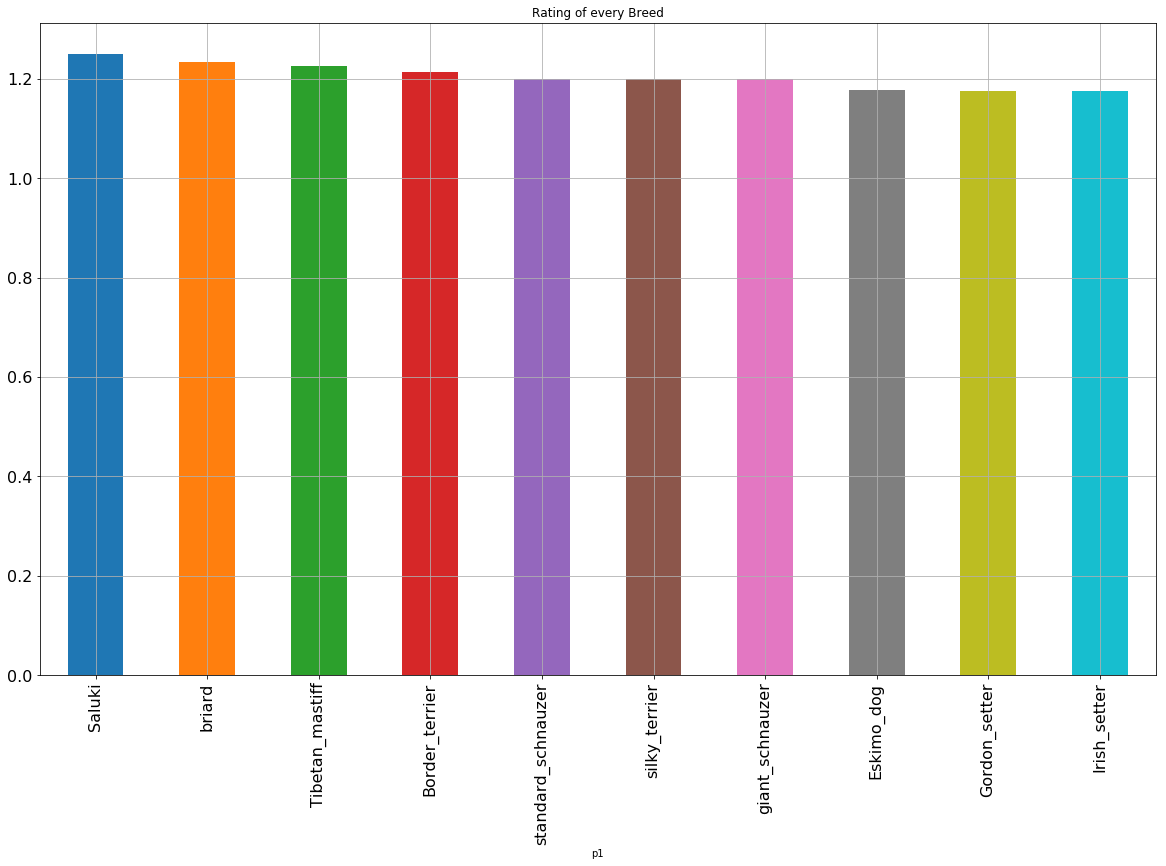

In [304]:
# 评级均值前10名的狗的品种柱状图绘制
p1_Rating.sort_values(ascending = False).head(10).plot(kind='bar',title='Rating of every Breed',figsize=(20, 12),fontsize=16,grid = True)

#### 分析和结论
1. 由计算结果和柱状图可知，Top5的狗的品种为 **Saluki，briard，Tibetan_mastiff，Border_terrier，standard_schnauzer**。
2. 推文图片中是狗的情况下，被提及最多的狗的品种统计情况，其中Top3为 **golden_retriever，Labrador_retriever，Pembroke**。这三种狗可能也是最为常见的。

### 2. 推文中狗的评级和转发量、点赞量的相关性

通过计算推文中狗的评级和转发量、点赞量之间的相关系数，分析它们之间的相关性。

#### 代码

In [305]:
twitter_archive_enhanced_clean_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1473 entries, 0 to 2073
Data columns (total 25 columns):
tweet_id                 1473 non-null object
jpg_url                  1473 non-null object
img_num                  1473 non-null int64
p1                       1473 non-null object
p1_conf                  1473 non-null float64
p1_dog                   1473 non-null bool
p2                       1473 non-null object
p2_conf                  1473 non-null float64
p2_dog                   1473 non-null bool
p3                       1473 non-null object
p3_conf                  1473 non-null float64
p3_dog                   1473 non-null bool
in_reply_to_status_id    1473 non-null int64
in_reply_to_user_id      1473 non-null int64
timestamp                1473 non-null datetime64[ns]
source                   1473 non-null object
text                     1473 non-null object
expanded_urls            1473 non-null object
rating_numerator         1473 non-null int64
rating_denominator

In [306]:
# 推文中对象为狗时，评级和转发量的相关系数
twitter_archive_enhanced_clean_p1.RATING.corr(twitter_archive_enhanced_clean_p1.retweet_count)

0.32533262766017329

In [307]:
# 推文中对象为狗时，评级和点赞量的相关系数
twitter_archive_enhanced_clean_p1.RATING.corr(twitter_archive_enhanced_clean_p1.favorite_count)

0.43169993505014498

#### 分析和结论

* 相关系数均为正数，所以评级和转发量（或点赞量）为正相关性，当评级较高时，转发量和点赞量也会增加。
* 0.31和0.43较为接近，所以评级与转发量的变化过程、评级和点赞量的变化过程，这两种变化过程有着较高的相似度。

### 3. 如果推文中提到的对象不是狗，是否会影响转发量、点赞量和评级

通过分析1已经分析了推文中对象为狗时的转发量和点赞量，并得到了相关系数。有了这个这基础，我们只要关注在推文中没有狗时，转发量、点赞量和评级均值是否会减少，相关性会发生什么变化。

#### 代码

In [308]:
# p1_dog为False的推文中提到的就不是狗。所以建立 twitter_archive_enhanced_clean_p1_NotDog，汇总不是狗的数据。
twitter_archive_enhanced_clean_p1_NotDog = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean.p1_dog == False]

In [309]:
twitter_archive_enhanced_clean_p1_NotDog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 6 to 2074
Data columns (total 25 columns):
tweet_id                 515 non-null object
jpg_url                  515 non-null object
img_num                  515 non-null int64
p1                       515 non-null object
p1_conf                  515 non-null float64
p1_dog                   515 non-null bool
p2                       515 non-null object
p2_conf                  515 non-null float64
p2_dog                   515 non-null bool
p3                       515 non-null object
p3_conf                  515 non-null float64
p3_dog                   515 non-null bool
in_reply_to_status_id    515 non-null int64
in_reply_to_user_id      515 non-null int64
timestamp                515 non-null datetime64[ns]
source                   515 non-null object
text                     515 non-null object
expanded_urls            515 non-null object
rating_numerator         515 non-null int64
rating_denominator       515 non-null 

In [310]:
twitter_archive_enhanced_clean_p1_NotDog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515 entries, 6 to 2074
Data columns (total 25 columns):
tweet_id                 515 non-null object
jpg_url                  515 non-null object
img_num                  515 non-null int64
p1                       515 non-null object
p1_conf                  515 non-null float64
p1_dog                   515 non-null bool
p2                       515 non-null object
p2_conf                  515 non-null float64
p2_dog                   515 non-null bool
p3                       515 non-null object
p3_conf                  515 non-null float64
p3_dog                   515 non-null bool
in_reply_to_status_id    515 non-null int64
in_reply_to_user_id      515 non-null int64
timestamp                515 non-null datetime64[ns]
source                   515 non-null object
text                     515 non-null object
expanded_urls            515 non-null object
rating_numerator         515 non-null int64
rating_denominator       515 non-null 

In [311]:
# 分析推文对象不是狗的数据
twitter_archive_enhanced_clean_p1_NotDog.describe()
# 由此可知，当推文中不是狗时，推文转发量均值为2708.2，点赞量均值为7829.4，对象评级均值为0.949.

,img_num,p1_conf,p2_conf,p3_conf,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,RATING
count,515.000000,515.000000,5.150000e+02,5.150000e+02,5.150000e+02,5.150000e+02,515.000000,515.000000,515.000000,515.000000,515.000000
mean,1.172816,0.536453,1.159491e-01,5.631393e-02,1.226892e+16,7.334535e+07,10.116505,10.526214,2708.201942,7829.380583,0.948614
std,0.517438,0.295196,9.318454e-02,4.559812e-02,9.218627e+16,5.504890e+08,10.818183,8.548147,4548.438306,11395.510254,0.294113
min,1.000000,0.059033,1.011300e-08,1.740170e-10,0.000000e+00,0.000000e+00,0.000000,10.000000,34.000000,108.000000,0.000000
25%,1.000000,0.276592,4.617995e-02,1.833315e-02,0.000000e+00,0.000000e+00,8.000000,10.000000,577.500000,1502.000000,0.800000
50%,1.000000,0.478616,9.914020e-02,4.917630e-02,0.000000e+00,0.000000e+00,10.000000,10.000000,1121.000000,3155.000000,1.000000
75%,1.000000,0.821904,1.602395e-01,8.308555e-02,0.000000e+00,0.000000e+00,12.000000,10.000000,2866.000000,9457.500000,1.200000
max,4.000000,1.000000,4.880140e-01,2.551820e-01,7.590995e+17,4.196984e+09,204.000000,170.000000,40437.000000,94035.000000,1.400000


In [312]:
# 分析推文对象是狗的数据
twitter_archive_enhanced_clean_p1.describe()
# 由此可知，当推文中是狗时，推文转发量均值为2787.1，比不是狗的推文的转发量增加了1.0%；推文中是狗时的点赞量均值为9296.7，比不是狗的推文的转发量增加了18.7%；推文中是狗时的评级均值为1.091，比不是狗的推文的转发量增加了15.0%.

,img_num,p1_conf,p2_conf,p3_conf,in_reply_to_status_id,in_reply_to_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,RATING
count,1473.000000,1473.000000,1473.000000,1.473000e+03,1.473000e+03,1.473000e+03,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,1.214528,0.614183,0.141111,6.165841e-02,6.606355e+15,3.988987e+07,11.493551,10.538357,2787.054311,9296.704005,1.091051
std,0.575903,0.260397,0.102511,5.262158e-02,6.762418e+16,4.073556e+08,7.695380,6.858334,4778.951799,12726.378354,0.171454
min,1.000000,0.044333,0.000023,2.160900e-07,0.000000e+00,0.000000e+00,1.000000,2.000000,15.000000,81.000000,0.200000
25%,1.000000,0.391471,0.057091,1.524340e-02,0.000000e+00,0.000000e+00,10.000000,10.000000,655.000000,2224.000000,1.000000
50%,1.000000,0.615741,0.126758,4.981050e-02,0.000000e+00,0.000000e+00,11.000000,10.000000,1437.000000,4480.000000,1.100000
75%,1.000000,0.852088,0.203671,9.499060e-02,0.000000e+00,0.000000e+00,12.000000,10.000000,3240.000000,11692.000000,1.200000
max,4.000000,0.999956,0.467678,2.734190e-01,8.558181e+17,4.196984e+09,165.000000,150.000000,79116.000000,132318.000000,1.400000


In [313]:
# 推文中对象不是狗时，评级和转发量的相关系数
twitter_archive_enhanced_clean_p1_NotDog.RATING.corr(twitter_archive_enhanced_clean_p1_NotDog.retweet_count)

0.30924095286938907

In [314]:
# 推文中对象不是狗时，评级和点赞量的相关系数
twitter_archive_enhanced_clean_p1_NotDog.RATING.corr(twitter_archive_enhanced_clean_p1_NotDog.favorite_count)

0.39229203348256947

#### 分析和结论

* 相关系数均为正数，相关系数也较为接近，这两点和推文中为狗时情况一样。
* 推文为狗时两个相关系数为0.31和0.43，推文不为狗时的系数为0.31和0.39，与前者非常接近。推文评级和转发量的变化过程，评级和点赞量的变化过程，与推文对象是否为狗没有关系，变化过程也非常相似。
* 当对象是狗的推文相比不是狗的推文，转发量均值变化很小，点赞量均值和评级均值会有15%左右的变化。

# 数据输出

将合并清洗后数据写出到twitter_archive_master.csv

#### 代码

In [315]:
twitter_archive_enhanced_clean.to_csv('twitter_archive_master.csv', index = False)